In [3]:
import os
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


img_size = (128, 128)  # Taille des images (modifiable)
X, y = [], []

# Chargement des images
for label, category in enumerate(["no", "yes"]):  # "no" et "yes" correspondent aux noms des dossiers contenants les images sans et avec tumeurs
    for file in os.listdir(category):  # Pas besoin de chemin absolu
        img_path = os.path.join(category, file)
        img = load_img(img_path, target_size=img_size)  # Charger l'image
        img_array = img_to_array(img) / 255.0  # Normalisation
        X.append(img_array)
        y.append(label)

# Conversion en array numpy
X = np.array(X)
y = np.array(y)

# Séparation en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Affichage des formes
print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test: {X_test.shape}, Labels: {y_test.shape}")


Train: (202, 128, 128, 3), Labels: (202,)
Test: (51, 128, 128, 3), Labels: (51,)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,      # Rotation aléatoire jusqu'à 20°
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2, # Décalage vertical
    shear_range=0.2,        # Transformation affine
    zoom_range=0.2,         # Zoom aléatoire
    horizontal_flip=True,   # Flip horizontal
    fill_mode='nearest'     # Complète les pixels manquants
)

# Appliquer le data augmentation sur X_train
datagen.fit(X_train)

In [77]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LeakyReLU

# Création du modèle séquentiel
model = Sequential()

# Première couche convolutionnelle
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))

# Deuxième couche convolutionnelle
model.add(Conv2D(64, (3,3)))
model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D((2, 2)))

# Troisième couche convolutionnelle
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# On aplatit la sortie pour la couche dense
model.add(Flatten())

# Couches denses (fully connected)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout pour éviter le surapprentissage (overfitting)

# Couche de sortie avec activation sigmoid pour classification binaire
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Entraînement du modèle
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Sauvegarder le modèle après entraînement
model.save("brain_tumor_model.h5")

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.5336 - loss: 0.7098 - val_accuracy: 0.6078 - val_loss: 0.6769
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.5581 - loss: 0.6575 - val_accuracy: 0.6471 - val_loss: 0.6409
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.6269 - loss: 0.6217 - val_accuracy: 0.6471 - val_loss: 0.6348
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.6520 - loss: 0.6380 - val_accuracy: 0.6471 - val_loss: 0.6144
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.6119 - loss: 0.6223 - val_accuracy: 0.6863 - val_loss: 0.5834
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.6993 - loss: 0.5950 - val_accuracy: 0.7255 - val_loss: 0.4849
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.6742 - loss: 0.5793 - val_accuracy: 0.6863 - val_loss: 0.5884
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.6783 - loss: 0.5972 - val_accuracy: 0.7647 - val_loss:

In [79]:
# Evaluation sur l'ensemble de test 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7859 - loss: 0.4819
Test Accuracy: 0.8039


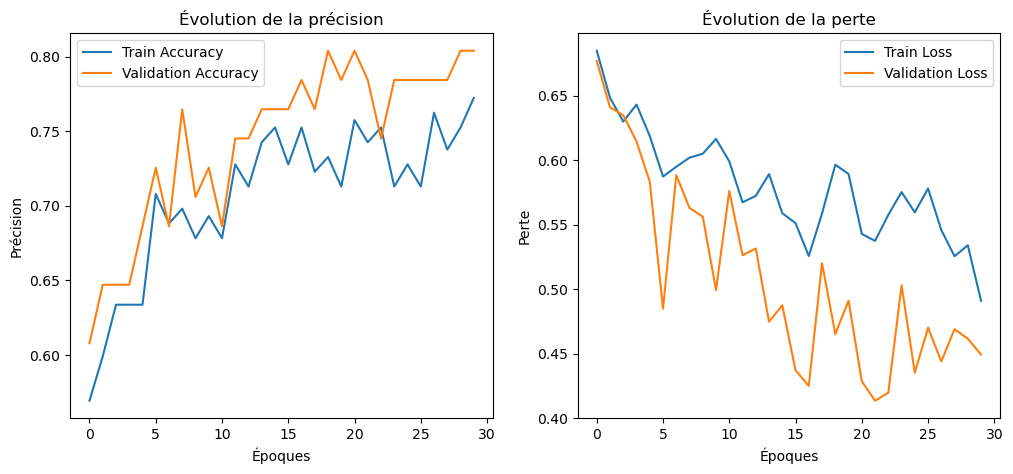

In [80]:
import matplotlib.pyplot as plt

# Récupérer l'historique d'entraînement
history_dict = history.history

# Courbe de la précision (accuracy)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title('Évolution de la précision')

# Courbe de la perte (loss)
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Évolution de la perte')

plt.show()
